Created by Michal Bukowski (michal.bukowski@tuta.io) under GPL-3.0 license as a part of the [dge-ontology](https://github.com/michalbukowski/dge-ontology) repository

# DGE-ontology
This Jupyter notebook aims at ontology analysis and visualisation for DGE results obtained using Salmon and DESeq2. The exemplary input contains metadata on _Staphylococcus aureus_ RN4220 transcriptome and output from [rnaseq-pipeline-2](https://github.com/michalbukowski/rnaseq-pipeline-2) executed for two strains sampled in the logarithmic growth phase: a wild type (`wt_lg`) vs. $\Delta$_saoC_ mutant (`mt_lg`). Execution of subsequent cells in many instances relies on the output of preceeding cells, thus cells should be executed in the order as presented in this notebook.

<u>Notebook cell output has been saved in the original (repository) version of the notebook</u>. If rerun for the exemplary data, it should give the same results. All visualisations are saved to `output` directory as high-resolution PNG files.

First necessary imports and environment setup.

In [1]:
# Do the necessary imports.
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Circle, Wedge
from collections import defaultdict
from scipy.stats import hypergeom
from PIL import Image

# Configure the environments to make sure the way
# figures are displayed is the same as they are saved
%config InlineBackend.print_figure_kwargs = {'bbox_inches': None}

# Attempt to create a directory for output files,
# in case it does not exist.
! mkdir -p "output"

## Functions, declarations
Four helper functions used for data analysis. Details on each are provided in doc-strings and comments in the code.

In [2]:
def get_sign(pval, trend):
    '''For a p-value falling into a given bin and a trend
       returns a string of asterisks and a hex color. Arguments:
       pval  -- p-value
       trend -- trend (under/normal/over)
       Returns:
       sign  -- a string of asterisk or an empty string
       color -- color encoded in a hex string
    '''
    sign  = ''
    color = 'black'
    if trend == 'over':
        if pval <= 0.001:
            sign = '***'
        elif pval <= 0.01:
            sign = '**'
        elif pval <= 0.05:
            sign = '*'
        if pval <= 0.05:
            color = '#990000' #if trend == 'over' else '#0044aa'
    return sign, color

In [3]:
def hypgeoprob(total_size, sample_size, total_cases, sample_cases):
    '''Providex a cumulative probability from hypogeometric distribution for
       a given total_size of a population, total_cases in the whole population,
       a sample_size sample from the population that contains sample_cases.
       That is a probability of drawing sample_cases or less when having given
       sample_size, total_size and total_cases. Or the probability of sample_cases or more,
       whichever smaller. Arguments:
       total_size   -- number of elements in the total set
       sample_size  -- number of element in a sample from the total set
       total_cases  -- number of elements of interest in the total set
       sample_cases -- number of elements of interest in the from the total set
       Returns:
       prob_1 or prob_2 -- left tail or right tail cumulative probability, whichever smaller,
                           the left tail cumulative probability is given a minus sign
                           that symbolises under-representation in the sample
    '''
    # Left tail cumulative probability of sample_cases or less.
    prob_1 = hypergeom.cdf(sample_cases,    total_size, total_cases, sample_size)
    # Right tail cumulative probability of sample_cases or more.
    prob_2 = hypergeom.sf(sample_cases - 1, total_size, total_cases, sample_size) 
    if prob_1 <= prob_2: 
        return -1*prob_1
    else: 
        return prob_2

In [4]:
def count_onts(fin_df):
    '''Given a DataFrame with DESeq2 DGE results for all transcripts merged on locus_tag
       with semicolon-separated ontologies in the 'cog' column, 'ncRNA' and 'tRNA' types
       in the 'type' column as well as not-NA values in the 'vfdbont' column
       (labeled as 'Virulence factors'), counts occurrences of all ontologies
       across all rows and puts the resutls in a dictionary ontology -> count. Arguments:
       fin_df -- DataFrame that contains DESeq2 DGE results for all transcripts merged
                 with the 'cog' and 'type' columns from metadata on locus_tag
       Returns:
       ont_counts -- ontology -> count dictionary (defaultdict with 0 as the default value)
    '''
    # Rename 'Unknown' ontology to 'Function unknown' and assigned it to
    # rows with NA values.
    fin_df = fin_df.copy()
    fin_df.loc[fin_df['cog'] == 'Unknown', 'cog'] = 'Function unknown'
    fin_df.loc[:, 'cog'].fillna('Function unknown', inplace=True)
    ont_counts = defaultdict(int)
    
    # Add 'ncRNA' and 'tRNA' ontologies based on the sequence type for a locus.
    for gb_key in['ncRNA', 'tRNA']:
        fin_df.loc[fin_df['type'] == gb_key, 'cog'] = gb_key
    
    # Fetch semicolon-separated ontologies from the 'cog' column.
    for cogs in fin_df['cog']:
        for item in cogs.split(';'):
            ont_counts[item.strip()] += 1
            
    # Count not-NA values of the 'vfdbont' column as 'Virulence factors' occurrences.
    ont_counts['Virulence factors'] = fin_df['vfdbont'].notna().sum()
    return ont_counts

In [5]:
def collect_folds(filt_df):
    '''Given a DataFrame with filtrated (truly differentiating) DESeq2 DGE results
       merged on locus_tag with semicolon-separated ontologies in the 'cog' column,
       'ncRNA' and 'tRNA' types in the 'type' column as well as not-NA values
       in the 'vfdbont' column (labeled as 'Virulence factors'), collects
       log2FoldChange values for occurrences of all ontologies across all rows
       and puts the resutls in a dictionary ontology -> [log2FoldChange, ... ]. Arguments:
       filt_df -- DataFrame that contains filtrated DESeq2 DGE results merged with
                  the 'cog' and 'type' columns from metadata on locus_tag
       Returns:
       ont_counts -- ontology -> [log2FoldChange, ... ] dictionary
                     (defaultdict with [] as the default value)
    '''
    # Rename 'Unknown' ontology to 'Function unknown' and assigned it to
    # rows with NA values.
    filt_df = filt_df.copy()
    ont_counts = defaultdict(list)
    filt_df.loc[filt_df['cog'] == 'Unknown', 'cog'] = 'Function unknown'
    filt_df.loc[:, 'cog'].fillna('Function unknown', inplace=True)

    # Collect log2FoldChange values for each of semicolon-separated ontologies
    # from the 'cog' column.
    for _, (fold, cogs) in filt_df['log2FoldChange cog'.split()].iterrows():
        for item in cogs.split(';'):
            ont_counts[item.strip()].append(fold)
    ont_counts = { ont : np.array(folds) for ont, folds in ont_counts.items() }
    
    # Collect log2FoldChage values for 'ncRNA' and 'tRNA' ontologies
    # based on the sequence type for a locus.
    tRNAs = filt_df.loc[filt_df['type'] == 'tRNA', 'log2FoldChange'].to_numpy()
    if tRNAs.shape[0] > 0:
        ont_counts['tRNA'] = tRNAs
    ncRNAs = filt_df.loc[filt_df['type'] == 'ncRNA', 'log2FoldChange'].to_numpy()
    if tRNAs.shape[0] > 0:
        ont_counts['ncRNA'] = ncRNAs
    # Collect log2FoldChage values for not-NA values of the 'vfdbont' column
    # assign to 'Virulence factors' key.
    vfs = filt_df.loc[filt_df['vfdbont'].notna(), 'log2FoldChange'].to_numpy()
    if vfs.shape[0] > 0:
        ont_counts['Virulence factors'] = vfs

    return ont_counts

## Data processing
In this section input data is read into Pandas DataFrame objects, and then pre-processed for visualistaion purposes. Details are provided in comments in the code.

In [6]:
# Load DESeq2 DGE results for all transcripts (locus_tags)
# from two groups being compared
# (wt_lg - wild type, mt_lg - mutant).
dge_df = pd.read_csv(
    'input/rn_wt_lg_mt_lg_ISR_0.05.tsv',
    index_col='locus_tag',
    sep='\t'
)
display(dge_df.info())
dge_df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 3334 entries, SAOUHSC_03055 to srn_1040_sRNA92
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   baseMean        2506 non-null   float64
 1   log2FoldChange  2506 non-null   float64
 2   lfcSE           2506 non-null   float64
 3   pvalue          2506 non-null   float64
 4   padj            2117 non-null   float64
dtypes: float64(5)
memory usage: 156.3+ KB


None

,baseMean,log2FoldChange,lfcSE,pvalue,padj
locus_tag,,,,,
SAOUHSC_03055,1070.864497,0.206305,0.082534,3.062734e-03,3.572446e-02
SAOUHSC_03054,27.772542,0.198024,0.448641,9.736177e-03,8.146832e-02
SAOUHSC_03053,307.974468,0.631638,0.129705,7.086663e-08,4.286419e-06
SAOUHSC_03051,383.174953,0.830312,0.124922,1.720980e-12,3.643314e-10
SAOUHSC_03049,644.449841,0.782655,0.110304,7.496961e-14,1.983883e-11


In [7]:
# Load metadata for all transcripts (locus_tags).
meta_df = pd.read_csv(
    'input/rn.tsv',
    index_col='locus_tag',
    sep='\t'
)
display(meta_df.info())
meta_df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 3465 entries, SAOUHSC_00001 to srn_5130_Sau6728
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   type     3465 non-null   object
 1   product  3465 non-null   object
 2   vfdbont  133 non-null    object
 3   cog      2073 non-null   object
dtypes: object(4)
memory usage: 135.4+ KB


None

,type,product,vfdbont,cog
locus_tag,,,,
SAOUHSC_00001,CDS,chromosomal replication initiation ATPase DnaA,NaN,"Replication, recombination and repair"
SAOUHSC_00002,CDS,"DNA polymerase III, beta subunit",NaN,"Replication, recombination and repair"
SAOUHSC_00003,CDS,"ribosome-associated protein YbcJ, S4-like RNA ...",NaN,"Translation, ribosomal structure and biogenesis"
SAOUHSC_00004,CDS,recombinational DNA repair ATPase RecF,NaN,"Replication, recombination and repair"
SAOUHSC_00005,CDS,"DNA gyrase/topoisomerase IV, subunit B",NaN,"Replication, recombination and repair"


In [8]:
# Merge DGE results with metadata on locus_tag column.
fin_df = dge_df.merge(meta_df, on='locus_tag', how='left')
display(fin_df.info())
fin_df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 3334 entries, SAOUHSC_03055 to srn_1040_sRNA92
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   baseMean        2506 non-null   float64
 1   log2FoldChange  2506 non-null   float64
 2   lfcSE           2506 non-null   float64
 3   pvalue          2506 non-null   float64
 4   padj            2117 non-null   float64
 5   type            3334 non-null   object 
 6   product         3334 non-null   object 
 7   vfdbont         132 non-null    object 
 8   cog             2070 non-null   object 
dtypes: float64(5), object(4)
memory usage: 260.5+ KB


None

,baseMean,log2FoldChange,lfcSE,pvalue,padj,type,product,vfdbont,cog
locus_tag,,,,,,,,,
SAOUHSC_03055,1070.864497,0.206305,0.082534,3.062734e-03,3.572446e-02,CDS,50S ribosomal protein L34,NaN,"Translation, ribosomal structure and biogenesis"
SAOUHSC_03054,27.772542,0.198024,0.448641,9.736177e-03,8.146832e-02,CDS,ribonuclease P,NaN,"Translation, ribosomal structure and biogenesis"
SAOUHSC_03053,307.974468,0.631638,0.129705,7.086663e-08,4.286419e-06,CDS,tRNA modification GTPase TrmE,NaN,"Translation, ribosomal structure and biogenesis"
SAOUHSC_03051,383.174953,0.830312,0.124922,1.720980e-12,3.643314e-10,CDS,16S rRNA methyltransferase GidB,NaN,"Translation, ribosomal structure and biogenesis"
SAOUHSC_03049,644.449841,0.782655,0.110304,7.496961e-14,1.983883e-11,CDS,"chromosome segregation protein Spo0J, contains...",NaN,"Cell cycle control, cell division, chromosome ..."


In [9]:
# Filter fin_df (all DGE results merged with metadata)
# based on log2FoldChange (fold_th) and padj/FDR (fdr_th) thresholds.
fold_th = 0.58
fdr_th  = 0.05
filt_df = fin_df[
    (fin_df['log2FoldChange'].abs() >= fold_th) &
    (fin_df['padj'] <= fdr_th)
]
filt_df.info()
filt_df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 59 entries, SAOUHSC_03053 to srn_3270_sRNA259
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   baseMean        59 non-null     float64
 1   log2FoldChange  59 non-null     float64
 2   lfcSE           59 non-null     float64
 3   pvalue          59 non-null     float64
 4   padj            59 non-null     float64
 5   type            59 non-null     object 
 6   product         59 non-null     object 
 7   vfdbont         5 non-null      object 
 8   cog             43 non-null     object 
dtypes: float64(5), object(4)
memory usage: 4.6+ KB


,baseMean,log2FoldChange,lfcSE,pvalue,padj,type,product,vfdbont,cog
locus_tag,,,,,,,,,
SAOUHSC_03053,307.974468,0.631638,0.129705,7.086663e-08,4.286419e-06,CDS,tRNA modification GTPase TrmE,NaN,"Translation, ribosomal structure and biogenesis"
SAOUHSC_03051,383.174953,0.830312,0.124922,1.720980e-12,3.643314e-10,CDS,16S rRNA methyltransferase GidB,NaN,"Translation, ribosomal structure and biogenesis"
SAOUHSC_03049,644.449841,0.782655,0.110304,7.496961e-14,1.983883e-11,CDS,"chromosome segregation protein Spo0J, contains...",NaN,"Cell cycle control, cell division, chromosome ..."
SAOUHSC_03025,34.983929,1.611926,0.370053,6.853774e-07,2.961110e-05,CDS,pyrrolidone-carboxylate peptidase (N-terminal ...,NaN,"Posttranslational modification, protein turnov..."
SAOUHSC_03024,141.515215,0.759492,0.180063,1.327875e-06,5.303984e-05,CDS,predicted sulfurtransferase,NaN,Unknown


In [10]:
# Show general statistics.
print('Total transcripts:', fin_df.shape[0])
print('Expressed transcripts:', fin_df['log2FoldChange'].notna().sum())
print('Filtered results:', filt_df.shape[0])
print('Up:  ', (filt_df['log2FoldChange'] > 0.0).sum())
print('Down:', (filt_df['log2FoldChange'] < 0.0).sum())

Total transcripts: 3334
Expressed transcripts: 2506
Filtered results: 59
Up:   23
Down: 36


## Ontology over-representation analysis
Firstly, an analysis of over-representaion of ontologies among differentiating transcripts is performed. The analysis is based on hypergeometric distribution. Important aspects are explained in comments in the code.

In [11]:
# Total size is the number of all analysed transcripts,
# sample size, the number of truly differientiating results
# (filtered results),
total_size = fin_df.shape[0]
sample_size = filt_df.shape[0]
# Create a new DataFrame for overrepresentation analysis.
columns = ('ont pval trend total_size sample_size ' +
           'total_cases sample_cases ' +
           'downreg_cases upreg_cases expected').split()
ont_df = pd.DataFrame(columns=columns)

# Calculate total number of each ontology occurrences,
# and the number of occurences of each ontology among
# filtered results.
tot_ont_counts = count_onts(fin_df)
filt_ont_folds = collect_folds(filt_df)

# For each ontology (sorted by the number of occurences in all results, descending)
# add a row to ont_df with results of overrepresentation analysis.
for ont in sorted(tot_ont_counts, key=lambda ont: tot_ont_counts[ont], reverse=True):
    # Fetch the number of total cases of a given ontology
    # (the number among all transcripts).
    total_cases  = tot_ont_counts[ont]
    # Fetch the number of sample cases of a given ontology
    # (the number among differentiating transcripts).
    if ont in filt_ont_folds:
        # The number of occurences is equal to the number of
        # log2FoldChange values in the item list.
        sample_cases = len(filt_ont_folds[ont])
        # Additionaly count separately up and down-regulated cases.
        downreg_cases, upreg_cases = sum(filt_ont_folds[ont] <= 0), sum(filt_ont_folds[ont] > 0)
    else:
        # If the key is not in filt_ont_folds that means no occurences are observed.
        sample_cases, downreg_cases, upreg_cases = 0, 0, 0
    # Count the expected number of occurences of a given ontology
    # among filtered (differentiating) results.
    expected = int( round(total_cases/total_size * sample_size) )

    # Calculate cumulative probability and slapn on a given ontology
    # a proper label: under(-represented), over(-represented), normal.
    pval = hypgeoprob(total_size, sample_size, total_cases, sample_cases)
    if pval < -0.05 or pval > 0.05:
        trend = 'normal'
    else:
        trend = 'under' if pval < 0.0 else 'over'
    pval = abs(pval)

    # Put the collected statistics into the ont_df DataFrame.
    ont_df.loc[ ont_df.shape[0] ] = ont, pval, trend, total_size, sample_size, \
                                    total_cases, sample_cases, \
                                    downreg_cases, upreg_cases, expected

# Replace the default numeric DataFrame index with the values
# of ontology names (the 'ont' column).
ont_df.set_index('ont', drop=True, inplace=True)
ont_df

,pval,trend,total_size,sample_size,total_cases,sample_cases,downreg_cases,upreg_cases,expected
ont,,,,,,,,,
Function unknown,5.197044e-01,normal,3334,59,1039,18,10,8,18
ncRNA,9.327704e-05,under,3334,59,481,0,0,0,9
Amino acid transport and metabolism,3.883578e-09,over,3334,59,227,19,13,6,4
"Translation, ribosomal structure and biogenesis",4.962336e-01,normal,3334,59,207,3,0,3,4
Inorganic ion transport and metabolism,3.299576e-01,normal,3334,59,164,4,3,1,3
Carbohydrate transport and metabolism,4.554632e-01,normal,3334,59,160,2,2,0,3
Transcription,2.609463e-01,normal,3334,59,146,1,1,0,3
Coenzyme transport and metabolism,5.506548e-01,normal,3334,59,139,2,1,1,2
Virulence factors,8.215072e-02,normal,3334,59,132,5,3,2,2


## Ontology visualisation combined with log2FoldChange values
Secondly, the results of the analysis combined with log2FoldChange values for all differentiating transcripts are visualised as a pie chart. Dimensions of wedges of the chart are proportional to the number of transcripts falling into each ontology (the numbers are also given in the chart, next to wedges). Pieces of wedges corresponding to down-regulated shoot inwards from the scaffold circle, whereas those corresponding to up-regulated, outwards. Values of log2FoldChange are mapped to blues and reds, respectively.

The chart is of very specific requirements, thus it is not rendered with any high-level Matplotlib plotting function. Instead Matplotlib patches such as Circle and Wedge have been utilised and the chart is plotted based on manually calculated coordinates. Consequently the code is a bit lengthy.

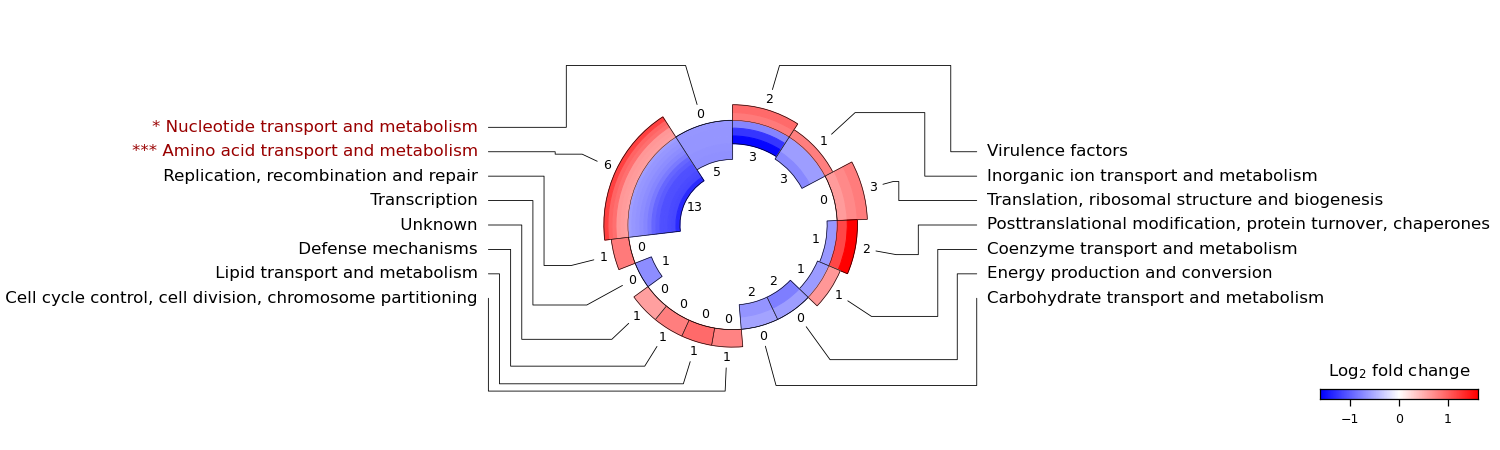

In [12]:
# Draw a pie chart shaped depiction of log2FoldChange values
# within ontologies found among truly differientiating results.
# Make each wedge (ontolohy) radial and arc dimensions proportional
# to the number of transripts falling into an ontology.
# Draw each transript as a subwedge of color proportinal to
# its logFoldChange value. Draw the part of each wedge that
# corresponds to up-regulated transcripts outwards in respect
# to the scaffold circle, and the other inwards.

# General scale factor. Change to increase or decrease the general
# wedge radial sizes.
scale = 0.05

# Collect the ontologies to which at least one truly differientiating
# result is assigned. Sort them according the number of transcirpts
# that fall in each ontology (descending).
onts_list = [ [ontname, folds] for ontname, folds in filt_ont_folds.items() if ontname != 'Function unknown']
onts_list = sorted(onts_list, key=lambda items: len(items[1]), reverse=True)
onts_list = [ [ontname, folds] for ontname, folds in onts_list if len(folds) >= 0 ]

# Find the maximal absolute log2FoldChange (for scaling the heatmap).
max_fold = np.max([ np.abs(folds).max() for _, folds in onts_list ])

# Collect sizes (lengths, the number of transripts) for each ontology.
# Square-root sizes (scaling). Next calculate arc sizes (360° scaffold
# circle pieces) proportional to scaled ontology sizes. Base on the arc
# sizes assign to each ontology wedge its beginning radius (theta).
# Shift each theta in order the third ontology starts at hour 12 (0°).
sizes   = np.array( [ len(ont[1]) for ont in onts_list ] )
scaled  = np.sqrt(sizes)
arcs    = 360*scaled / scaled.sum()
thetas  = np.append([0], arcs[:-1]).cumsum() + 90 - arcs[:2].sum()

# Calculate the fraction of positive log2FoldChange values for each ontology.
possizes = [ len([ value for value in ont[1] if value >= 0.0 ]) for ont in onts_list ]
posfracs = possizes / sizes

# Set the figure dimensions in inch. Calculate the ratio.
# That is necessary to calculate ranges of axes in order
# to avoid the circular shape turning into eliptical.
w, h = 10, 3.0
ratio = h/w

# Create a figure and axes.
fig = plt.figure(figsize=(w,h), facecolor='white', dpi=150)

ax = fig.add_axes([0.0, 0.0, 1.0, 1.0])
ax.set_axis_off()

# Create a new DataFrame to which geometrical measures of each
# ontology wedge will be collected. These measures will be
# used to position connectors and lables:
# theta -- start radius
# r_in  -- radial width of the wegde portion directed inwards
#          the scaffold circle (log2FoldChange < 0)
# r_out -- radial width of the wegde portion directed outwards
#          the scaffold circle (log2FoldChange > 0)
# text  -- wedge label (ontology name)
# sign  -- asterisks denoting significance thresholds for
#          up-regulated transcripts
# color -- label color (red if an ontology is over-represented)
label_cols = 'theta r_in r_out text sign color'.split()
labels_df = pd.DataFrame(columns=label_cols)

# General geometric measures of the pie chart:
# pie_r        -- the radius of the scaffold circle
# margin       -- margin between each wedge and the number
#                 of transcripts and also the connectors
# label_at     -- x at which ontology (wedge) labels
#                 are left-aligned on the right side or
#                 -x at which ontology (wedge) labels
#                 are right-aligned on the left side
# label_height -- vertical span a label is assumed to occupy
pie_r  = 0.3
margin = 0.03
label_at  = 0.7
label_height = 0.07

# Iterate over calculated thetas, arc sizes, scaled sizes, positive fractions and ontology list
# to fill up the labels_df DataFrame, i.e. measures of wedges corresponding to ontologies,
# as well as to draw subwedges corresponding to transcripts within each ontology.
for theta, arc, size, posfrac, rawdata in zip(thetas, arcs, scaled, posfracs, onts_list):
    # Calculate the "real" radial width of a wedge, i.e. the actual radial width of a wedge
    # based on the scaled number of transcript falling into an ontology
    # and an arbitrarily assumed scale.
    real_w = size*scale
    
    # Collect the ontology name as well as the positive and negative log2FoldChange values
    ontname  = rawdata[0]
    negfolds = sorted([ abs(fold) for fold in rawdata[1] if fold <  0.0 ])
    posfolds = sorted([ fold      for fold in rawdata[1] if fold >= 0.0 ])

    # Draw subwedges. Calculate their radial span as a fraction of the real radial width
    # of a wedge. Use a colors proportinal to log2FoldChange values scaled against the
    # maximal value (max_fold). Use scale of reds for up-regulated transcripts and of blues
    # for down-regulated ones.
    for i, fold in enumerate(negfolds):
        span = real_w*(1.0-posfrac) / len(negfolds)
        color = (1.0-abs(fold)/max_fold, 1.0-abs(fold)/max_fold, 1.0)
        ax.add_patch( Wedge((0.0, 0.0), pie_r-span*i, theta, theta+arc, width=span, linewidth=0.5, edgecolor=color, facecolor=color) )

    for i, fold in enumerate(posfolds):
        span = real_w*posfrac / len(posfolds)
        color = (1.0, 1.0-abs(fold)/max_fold, 1.0-abs(fold)/max_fold)
        ax.add_patch( Wedge((0.0, 0.0), pie_r+span*(i+1), theta, theta+arc, width=span, linewidth=0.5, edgecolor=color, facecolor=color) )

    # Sketch a wedge frame around already drawn subwedges.
    ax.add_patch( Wedge((0.0, 0.0), pie_r+posfrac*real_w, theta, theta+arc, width=real_w, fill=False, linewidth=0.3) )
    
    # Assigned color and optinally add asterisks to an ontology (wedge) label
    # if the ontology happens to be over-represented.
    sign, color = get_sign(*ont_df.loc[ontname, ['pval', 'trend']])

    # Recalculate degrees into radians. Add all collected and calculated measures to
    # labels_df DataFrame.
    theta_rad = (theta+0.5*arc)/180*np.pi
    labels_df.loc[ labels_df.shape[0] ] = theta_rad, pie_r-(1.0-posfrac)*real_w, pie_r+posfrac*real_w, ontname, sign, color

# Sketch the scaffold circle arcross already drawn wedges.
ax.add_patch( Circle((0.0, 0.0), pie_r, fill=False, linewidth=0.2, color='black') )

# Based on values from different columns from labels_df DataFrame, calculate
# coordinates of connectors fragments, number of transcript labels and
# ontology labels. Add the coordinates to labels_df DataFrame.
# numup_       -- labels for number of up-regulated transcripts,
#                 (outwards the wedges)
# numupdown_   -- labels for number of down-regulated transcripts,
#                 (inwards the wedges)
# Coordinates of connector points starting at a wedge and finishing at
# an ontology (wedge) label:
# conn_term_   -- start points at the wedge
# conn_proxy_  -- points on the outer scaffold circle
# conn_middle_ -- x and y values shared by next two middle points
# conn_init_   -- points at ontology (wedge) labels
labels_df['numup_x']   = np.cos(labels_df['theta']) * (labels_df['r_out'] + margin)
labels_df['numup_y']   = np.sin(labels_df['theta']) * (labels_df['r_out'] + margin)

labels_df['numdown_x'] = np.cos(labels_df['theta']) * (labels_df['r_in'] - margin)
labels_df['numdown_y'] = np.sin(labels_df['theta']) * (labels_df['r_in'] - margin)

labels_df['conn_term_x'] = np.cos(labels_df['theta']) * (labels_df['r_out'] + 2.0*margin)
labels_df['conn_term_y'] = np.sin(labels_df['theta']) * (labels_df['r_out'] + 2.0*margin)

proxy_r = labels_df['r_out'].max() + 3.0*margin

labels_df['conn_proxy_x'] = np.cos(labels_df['theta']) * (proxy_r)
labels_df['conn_proxy_y'] = np.sin(labels_df['theta']) * (proxy_r)

labels_df.sort_values('conn_proxy_y', ascending=False, inplace=True)
sub_index_left = labels_df.loc[ labels_df['conn_proxy_x'] <= 0.0 ].index
sub_index_right = labels_df.index.difference(sub_index_left, sort=False)

for sub_index in sub_index_left, sub_index_right:
    max_rank = sub_index.shape[0] // 2
    labels_df.loc[sub_index, 'rank'] = pd.Series(
        range(max_rank, max_rank-sub_index.shape[0], -1), index=sub_index)

labels_df.loc[sub_index_left, 'rank_norm'] = \
    (labels_df.loc[sub_index_left, 'rank'] + np.abs(labels_df.loc[sub_index_left,  'rank'].min()))
labels_df.loc[sub_index_left, 'rank_norm'] = \
    labels_df.loc[sub_index_left, 'rank_norm'] / labels_df.loc[sub_index_left,'rank_norm'].max()

labels_df.loc[sub_index_right, 'rank_norm'] = \
    (labels_df.loc[sub_index_right, 'rank'] + np.abs(labels_df.loc[sub_index_right,  'rank'].min()))
labels_df.loc[sub_index_right, 'rank_norm'] = \
    labels_df.loc[sub_index_right, 'rank_norm'] / labels_df.loc[sub_index_right,'rank_norm'].max()

labels_df['rank_norm'].fillna(0.0, inplace=True)

labels_df['conn_init_y'] = label_height * labels_df['rank']
labels_df.loc[labels_df['conn_term_x'] <  0, 'conn_init_x'] = label_at * -1
labels_df.loc[labels_df['conn_term_x'] >= 0, 'conn_init_x'] = label_at

conn_range = label_at - proxy_r

# Upper right quarter labels (if x-axis reveresed, default).
sub_index = labels_df[
    (labels_df['conn_init_x'] < 0) &
    (labels_df['conn_init_y'] < labels_df['conn_proxy_y'])
].index
step = conn_range / sub_index.shape[0]
labels_df.loc[sub_index, 'conn_middle_x'] = -1* proxy_r - step * np.arange(sub_index.shape[0]-1, -1, -1)

# Upper left quarter labels (if x-axis reveresed, default).
sub_index = labels_df[
    (labels_df['conn_init_x'] > 0) &
    (labels_df['conn_init_y'] < labels_df['conn_proxy_y'])
].index
step = conn_range / sub_index.shape[0]
labels_df.loc[sub_index, 'conn_middle_x'] = proxy_r + step * np.arange(sub_index.shape[0]-1, -1, -1)

# Lower right quarter labels (if x-axis reveresed, default).
sub_index = labels_df[
    (labels_df['conn_init_x'] < 0) &
    (labels_df['conn_init_y'] > labels_df['conn_proxy_y'])
].index
step = conn_range / sub_index.shape[0]
labels_df.loc[sub_index, 'conn_middle_x'] = -proxy_r - step * np.arange(1, sub_index.shape[0]+1, 1)

# Lower left quarter labels (if x-axis reveresed, default).
sub_index = labels_df[
    (labels_df['conn_init_x'] > 0) &
    (labels_df['conn_init_y'] > labels_df['conn_proxy_y'])
].index
step = conn_range / sub_index.shape[0]
labels_df.loc[sub_index, 'conn_middle_x'] = proxy_r + step * np.arange(1, sub_index.shape[0]+1, 1)

# Iterate over labels_df DataFrame and based on alread calculated
# geometric measures draw connectors and labels.
for i, row in labels_df.iterrows():
    x, y = row['numup_x'], row['numup_y']
    ax.text(x, y, ont_df.loc[row['text'], 'upreg_cases'], va='center', ha='center', fontsize=6.0)

    x, y = row['numdown_x'], row['numdown_y']
    ax.text(x, y, ont_df.loc[row['text'], 'downreg_cases'], va='center', ha='center', fontsize=6.0)

    X = row['conn_init_x conn_middle_x conn_middle_x conn_proxy_x conn_term_x'.split()]
    Y = row['conn_init_y conn_init_y   conn_proxy_y  conn_proxy_y conn_term_y'.split()]
    ax.plot(X, Y, linewidth=0.4, color='black', solid_joinstyle='round', solid_capstyle='round')

    x, y, text, sign, color = row['conn_init_x conn_init_y text sign color'.split()]
    if x < 0:
        x -= margin
        label = f'{text} {sign}'
        ha    = 'left'
    else:
        x += margin
        label = f'{sign} {text}'
        ha    = 'right'
    ax.text(x, y, label, va='center', ha=ha, color=color, fontsize=8.0)

# Set x-axis limits. Based on figure
# h/w ratio, calculate y-axis limits.
xrange = 4.3
xstart = -2.2
ax.set_xlim( xstart+xrange, xstart)
ax.set_ylim(-1*xrange/2*ratio,  xrange/2*ratio)

# Draw the log2FoldChange scale bar (heatmap) on separate axes, assuming
# arbitrary number of cells (color bands) and their widths (sizes).
bar_cell_size  = 0.05
bar_cell_count = 7
ax_bar = fig.add_axes([0.88, 0.1, bar_cell_size*ratio*bar_cell_count, bar_cell_size])
ax_bar.set_yticks([])
for spine in ['left', 'top', 'right', 'bottom']:
    ax_bar.spines[spine].set_linewidth(0.6)
ax_bar.tick_params(width=0.6, labelsize=6.0)
steps  = np.linspace(0.0, 1.0, 50)
colors = np.stack([steps, steps, np.ones(steps.shape[0])], axis=1)
steps  = np.linspace(1.0, 0.0, 50)[1:]
colors = np.vstack([colors, np.stack([np.ones(steps.shape[0]), steps, steps], axis=1)])
ax_bar.imshow(
    colors.reshape((1,99,3)),
    extent = (-max_fold, max_fold, 0, max_fold/(bar_cell_count + 1))
)
ax_bar.set_title('Log$_{2}$ fold change', fontsize=8.0)

# Save the figure.
path = 'output/ontologies.png'
fig.savefig(path, transparent=False, dpi=300)
Image.open(path).convert('RGB').save(path)